In [89]:

import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

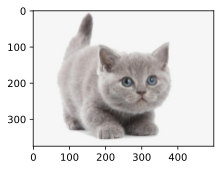

In [7]:
d2l.set_figsize()
img = Image.open('img/cat1.jpg')
d2l.plt.imshow(img)

In [8]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [9]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

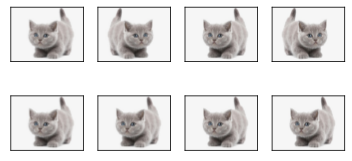

In [22]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

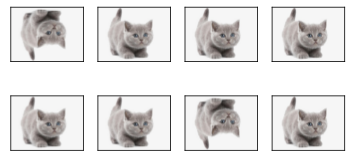

In [15]:
apply(img, torchvision.transforms.RandomVerticalFlip())

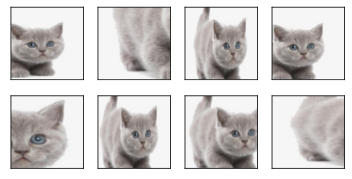

In [23]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)


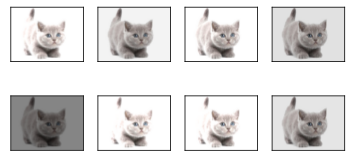

In [29]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

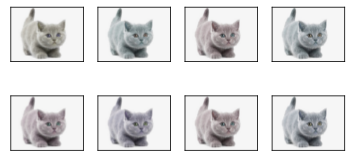

In [30]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

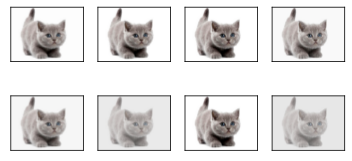

In [31]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))



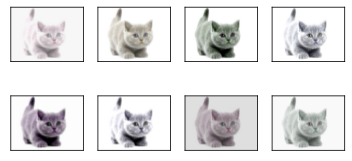

In [34]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)


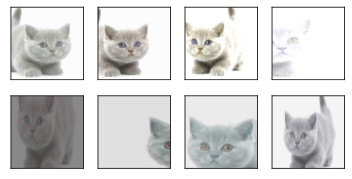

In [35]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)



0it [00:00, ?it/s]Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to C:\Users\50455/Datasets/CIFAR\cifar-10-python.tar.gz
100%|█████████▉| 170418176/170498071 [11:23<00:00, 209361.10it/s]Extracting C:\Users\50455/Datasets/CIFAR\cifar-10-python.tar.gz to C:\Users\50455/Datasets/CIFAR


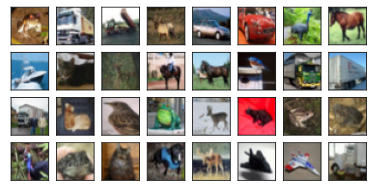

In [36]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="~/Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);



In [37]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])




In [56]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="~/Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [87]:

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [88]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)


In [90]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.3732, train acc 0.502, test acc 0.528, time 31.0 sec
epoch 2, loss 0.5003, train acc 0.644, test acc 0.579, time 31.0 sec
epoch 3, loss 0.2851, train acc 0.699, test acc 0.555, time 31.6 sec
epoch 4, loss 0.1880, train acc 0.737, test acc 0.675, time 31.2 sec
epoch 5, loss 0.1360, train acc 0.763, test acc 0.688, time 31.7 sec
epoch 6, loss 0.1036, train acc 0.782, test acc 0.682, time 32.1 sec
epoch 7, loss 0.0816, train acc 0.800, test acc 0.721, time 31.8 sec
epoch 8, loss 0.0653, train acc 0.819, test acc 0.726, time 31.9 sec
epoch 9, loss 0.0531, train acc 0.834, test acc 0.718, time 32.5 sec
epoch 10, loss 0.0444, train acc 0.848, test acc 0.730, time 33.0 sec
